# Сегментация печени: 4 архитектуры (nnU-Net, U-Net, YOLOv11-seg, SAM2)

Этот ноутбук реализует сравнение 4 подходов к сегментации печени на КТ снимках:
1. **nnU-Net** - основная архитектура с протоколом обучения
2. **U-Net** - классическая архитектура для сравнения
3. **YOLOv11-seg** - современный подход через ultralytics
4. **SAM2** - SOTA модель для zero-shot сегментации

## Ячейка 1: Установка и Импорт

In [1]:
# --- ЯЧЕЙКА 1: УСТАНОВКА И ИМПОРТЫ ---
import sys
import os

# 1. Установка основных библиотек
!pip install ultralytics pydicom medpy scikit-image scikit-learn matplotlib seaborn tqdm albumentations scipy

# 2. Установка библиотек для TotalSegmentator (работа с 3D)
!pip install TotalSegmentator dicom2nifti nibabel

# 3. PyTorch (убедитесь, что версия совпадает с CUDA)
!pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126

import shutil
import glob
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
import dicom2nifti
import nibabel as nib
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Ultralytics (YOLOv11 & SAM 2)
from ultralytics import YOLO, SAM

# Импорт TotalSegmentator
try:
    from totalsegmentator.python_api import totalsegmentator
    print("✅ TotalSegmentator успешно импортирован.")
except ImportError:
    print("⚠️ TotalSegmentator не установлен. Запустите pip install.")

# Настройки устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

# Сиды для воспроизводимости
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Создание папок
os.makedirs('./checkpoints', exist_ok=True)

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
Looking in indexes: https://download.pytorch.org/whl/cu126


d:\UrFU\LiverSegmentation\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ TotalSegmentator успешно импортирован.
Используемое устройство: cuda


## Ячейка 2: Подготовка Данных и Конвертация для YOLO

In [2]:
# --- ЯЧЕЙКА 2: ГЕНЕРАЦИЯ ДАННЫХ ЧЕРЕЗ TOTALSEGMENTATOR (SAFE MODE) ---
def prepare_data_with_totalsegmentator(dicom_root, output_dir='./processed_data_ts', yolo_dir='./yolo_dataset_ts'):
    """
    1. Ищет папки с сериями DICOM.
    2. Конвертирует в NIfTI.
    3. Запускает TotalSegmentator (поиск печени).
    4. Нарезает 3D объемы на 2D картинки для обучения.
    """
    # Очистка старых данных
    if os.path.exists(output_dir): shutil.rmtree(output_dir)
    if os.path.exists(yolo_dir): shutil.rmtree(yolo_dir)
    
    # Создаем структуру папок
    for s in ['train', 'val', 'test']:
        os.makedirs(f"{output_dir}/{s}/images", exist_ok=True)
        os.makedirs(f"{output_dir}/{s}/masks", exist_ok=True)
        os.makedirs(f"{yolo_dir}/images/{s}", exist_ok=True)
        os.makedirs(f"{yolo_dir}/labels/{s}", exist_ok=True)

    data_paths = {'train': [], 'val': [], 'test': []}
    
    # Поиск серий (папок, где > 10 файлов .dcm)
    print("Поиск серий DICOM...")
    series_dirs = [x[0] for x in os.walk(dicom_root) if len(glob.glob(os.path.join(x[0], '*.dcm'))) > 10]
    
    if not series_dirs:
        print("❌ DICOM серии не найдены.")
        return {}, ""

    print(f"Найдено {len(series_dirs)} серий. Начинаем обработку TotalSegmentator...")
    
    # --- ВАЖНО: Локальная переменная только для TotalSegmentator ---
    # Для PyTorch мы используем глобальную 'device' (которая cuda), 
    # а TotalSegmentator требует строку 'gpu'.
    ts_device = 'gpu' if torch.cuda.is_available() else 'cpu'
    print(f"TotalSegmentator настроен на: {ts_device}")

    global_idx = 0
    
    for series_path in tqdm(series_dirs, desc="Processing 3D Volumes"):
        try:
            # 1. Очистка временной папки
            for f in glob.glob('./temp_nifti/*'): 
                if os.path.isfile(f): os.remove(f)
                else: shutil.rmtree(f)
                os.makedirs('./temp_nifti', exist_ok=True)
            
            # 2. Конвертация DICOM -> NIfTI
            try:
                dicom2nifti.convert_directory(series_path, './temp_nifti', compression=True, reorient=True)
            except Exception as e:
                continue

            nifti_files = glob.glob('./temp_nifti/*.nii.gz')
            
            if not nifti_files: continue
            img_nifti_path = nifti_files[0]
            
            # 3. TotalSegmentator
            # Передаем ts_device ('gpu'), чтобы TS не падал
            try:
                totalsegmentator(img_nifti_path, './temp_nifti/segmentations', fast=True, roi_subset=['liver'], quiet=True, device=ts_device)
            except Exception as e:
                print(f"TS Failed on {series_path}: {e}")
                continue
                
            mask_nifti_path = './temp_nifti/segmentations/liver.nii.gz'
            if not os.path.exists(mask_nifti_path): 
                continue

            # 4. Загрузка 3D NIfTI
            img_obj = nib.load(img_nifti_path)
            msk_obj = nib.load(mask_nifti_path)
            
            # Транспонируем в (Z, X, Y)
            img_data = img_obj.get_fdata().transpose(2, 1, 0) 
            msk_data = msk_obj.get_fdata().transpose(2, 1, 0)
            
            # 5. Нормализация (Windowing)
            img_data = np.clip(img_data, -160, 240)
            img_data = (img_data + 160) / 400.0 * 255.0
            img_data = img_data.astype(np.uint8)
            
            # Разбиение на сеты
            r = random.random()
            if r < 0.75: split = 'train'
            elif r < 0.85: split = 'val'
            else: split = 'test'
            
            # 6. Сохранение слайсов
            for i in range(img_data.shape[0]):
                slc_img = img_data[i]
                slc_msk = msk_data[i]
                
                slc_img = np.rot90(slc_img)
                slc_msk = np.rot90(slc_msk)
                
                if np.sum(slc_msk) < 10:
                    continue
                    
                fname = f"ts_{global_idx:05d}.jpg"
                mask_fname = f"ts_{global_idx:05d}.png"
                
                p_img = f"{output_dir}/{split}/images/{fname}"
                p_msk = f"{output_dir}/{split}/masks/{mask_fname}"
                
                cv2.imwrite(p_img, slc_img)
                cv2.imwrite(p_msk, (slc_msk * 255).astype(np.uint8))
                data_paths[split].append((p_img, p_msk))
                
                # YOLO paths
                y_img_path = f"{yolo_dir}/images/{split}/{fname}"
                cv2.imwrite(y_img_path, slc_img)
                
                # Контуры для YOLO
                contours, _ = cv2.findContours(slc_msk.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                yolo_txt = f"{yolo_dir}/labels/{split}/{fname.replace('.jpg', '.txt')}"
                
                with open(yolo_txt, 'w') as f:
                    has_poly = False
                    for cnt in contours:
                        if cv2.contourArea(cnt) > 20:
                            poly = cnt.flatten().astype(float)
                            poly[0::2] /= slc_img.shape[1]
                            poly[1::2] /= slc_img.shape[0]
                            f.write(f"0 {' '.join(map(str, poly))}\n")
                            has_poly = True
                
                global_idx += 1
                
        except Exception as e:
            print(f"Ошибка обработки серии {series_path}: {e}")
            continue
            
    # YAML для YOLO
    yaml_content = f"path: {os.path.abspath(yolo_dir)}\ntrain: images/train\nval: images/val\ntest: images/test\nnames:\n  0: liver"
    with open(f"{yolo_dir}/data.yaml", 'w') as f: f.write(yaml_content)
    
    print(f"\nДанные готовы. Всего слайсов: {global_idx}")
    if len(data_paths['train']) > 0:
        print(f"Train: {len(data_paths['train'])}, Val: {len(data_paths['val'])}, Test: {len(data_paths['test'])}")
    else:
        print("⚠️ Внимание: Слайсы не созданы. Возможно, TotalSegmentator не нашел печень или проблемы с путями.")
        
    return data_paths, f"{yolo_dir}/data.yaml"

# Запуск
dicom_directory = './DICOM' 
data_paths, yolo_yaml_path = prepare_data_with_totalsegmentator(dicom_directory)

Поиск серий DICOM...
Найдено 16 серий. Начинаем обработку TotalSegmentator...
TotalSegmentator настроен на: gpu


Processing 3D Volumes:  81%|████████▏ | 13/16 [18:30<05:11, 103.71s/it]

Shape of output image is very big. Setting nr_threads_saving=1 to save memory.


Processing 3D Volumes: 100%|██████████| 16/16 [24:36<00:00, 92.31s/it] 


Данные готовы. Всего слайсов: 3585
Train: 3446, Val: 0, Test: 139


## Ячейка 2.5

In [3]:
# --- ЯЧЕЙКА 2.5: ПЕРЕРАСПРЕДЕЛЕНИЕ ДАННЫХ (ИСПРАВЛЕННАЯ) ---
import shutil
import random
import os
from glob import glob
from sklearn.model_selection import train_test_split

def redistribute_data(base_dir='./processed_data_ts', yolo_dir='./yolo_dataset_ts'):
    print("Перераспределение файлов (70% Train, 15% Val, 15% Test)...")
    
    # 1. Собираем все файлы (Рекурсивный поиск, чтобы найти везде)
    # Ищем все jpg файлы внутри папки base_dir
    all_images = glob(f"{base_dir}/**/*.jpg", recursive=True)
    all_masks = []
    
    valid_images = []
    
    print(f"Всего найдено изображений: {len(all_images)}")
    
    if len(all_images) == 0:
        print(f"❌ Файлы не найдены в {base_dir}. Проверьте, отработала ли Ячейка 2.")
        # Возвращаем пустые списки, чтобы не было KeyError
        return {'train': [], 'val': [], 'test': []}, ""

    # Ищем соответствующие маски
    for img_path in all_images:
        # Предполагаем, что маска имеет то же имя, но .png
        # И лежит в папке masks (параллельно images)
        # Структура может быть .../train/images/file.jpg -> .../train/masks/file.png
        # Или .../images/train/file.jpg -> .../masks/train/file.png
        
        basename = os.path.basename(img_path)
        mask_name = basename.replace('.jpg', '.png')
        
        # Пытаемся найти маску заменой 'images' на 'masks' в пути
        # Пример: ./data/train/images/1.jpg -> ./data/train/masks/1.png
        mask_path = img_path.replace('images', 'masks').replace('.jpg', '.png')
        
        if os.path.exists(mask_path):
            valid_images.append(img_path)
            all_masks.append(mask_path)
        else:
            # Если простая замена не сработала, пробуем найти рекурсивно (медленнее, но надежнее)
            # Обычно структура жесткая, так что простая замена должна работать, 
            # если Ячейка 2 отработала нормально.
            pass

    print(f"Найдено пар (изображение+маска): {len(valid_images)}")
    if len(valid_images) == 0:
        return {'train': [], 'val': [], 'test': []}, ""

    # 2. Разбиваем список
    zipped = list(zip(valid_images, all_masks))
    random.shuffle(zipped)
    valid_images, all_masks = zip(*zipped)

    # 70% Train, 15% Val, 15% Test
    # Сначала отделяем 30% (Val+Test)
    train_imgs, temp_imgs, train_msks, temp_msks = train_test_split(
        valid_images, all_masks, test_size=0.30, random_state=42
    )
    # Потом делим эти 30% пополам
    val_imgs, test_imgs, val_msks, test_msks = train_test_split(
        temp_imgs, temp_msks, test_size=0.50, random_state=42
    )
    
    splits = {
        'train': (train_imgs, train_msks),
        'val':   (val_imgs, val_msks),
        'test':  (test_imgs, test_msks)
    }

    # 3. Перемещаем файлы в НОВУЮ стандартную структуру
    # Новая структура будет: processed_data_ts/images/train, processed_data_ts/masks/train и т.д.
    final_paths = {'train': [], 'val': [], 'test': []}
    
    for split, (imgs, msks) in splits.items():
        print(f"Формирование {split}: {len(imgs)} файлов...")
        
        # Создаем целевые папки (стандартизируем путь: base/images/split)
        target_img_dir = f"{base_dir}/images/{split}"
        target_msk_dir = f"{base_dir}/masks/{split}"
        target_yolo_img_dir = f"{yolo_dir}/images/{split}"
        target_yolo_txt_dir = f"{yolo_dir}/labels/{split}"
        
        os.makedirs(target_img_dir, exist_ok=True)
        os.makedirs(target_msk_dir, exist_ok=True)
        os.makedirs(target_yolo_img_dir, exist_ok=True)
        os.makedirs(target_yolo_txt_dir, exist_ok=True)
        
        for i in range(len(imgs)):
            old_img_path = imgs[i]
            old_msk_path = msks[i]
            fname = os.path.basename(old_img_path)
            mask_fname = os.path.basename(old_msk_path)
            txt_name = fname.replace('.jpg', '.txt')
            
            # --- 1. PyTorch Files ---
            new_img_path = f"{target_img_dir}/{fname}"
            new_msk_path = f"{target_msk_dir}/{mask_fname}"
            
            # Перемещаем (если путь отличается)
            if os.path.abspath(old_img_path) != os.path.abspath(new_img_path):
                shutil.move(old_img_path, new_img_path)
                shutil.move(old_msk_path, new_msk_path)
            
            final_paths[split].append((new_img_path, new_msk_path))
            
            # --- 2. YOLO Files ---
            # Ищем старый файл YOLO (он мог быть в train, val или test)
            # Мы ищем файл с тем же именем в старой структуре yolo
            # Старая структура могла быть любой, поэтому ищем рекурсивно или перебором
            
            # Самый надежный способ: если мы переместили картинку для PyTorch,
            # мы просто копируем её же для YOLO в новую папку.
            # А вот текстовый файл (лейбл) нужно найти.
            
            new_y_img = f"{target_yolo_img_dir}/{fname}"
            
            # Копируем картинку в папку YOLO (или создаем симлинк, но копирование надежнее)
            if not os.path.exists(new_y_img):
                shutil.copy(new_img_path, new_y_img)
            
            # Ищем и перемещаем лейбл
            # Лейбл лежит где-то в yolo_dataset_ts/labels/...
            found_txt = False
            # Проверяем все возможные старые папки
            for search_split in ['train', 'val', 'test']:
                possible_old_txt = f"{yolo_dir}/labels/{search_split}/{txt_name}"
                if os.path.exists(possible_old_txt):
                    new_y_txt = f"{target_yolo_txt_dir}/{txt_name}"
                    if os.path.abspath(possible_old_txt) != os.path.abspath(new_y_txt):
                        shutil.move(possible_old_txt, new_y_txt)
                    found_txt = True
                    break
            
            if not found_txt:
                # Если лейбла нет, возможно, это пустой фон (без печени), это нормально для YOLO
                pass

    # Обновляем YAML для YOLO с правильными путями
    yaml_content = f"path: {os.path.abspath(yolo_dir)}\ntrain: images/train\nval: images/val\ntest: images/test\nnames:\n  0: liver"
    with open(f"{yolo_dir}/data.yaml", 'w') as f: f.write(yaml_content)

    return final_paths, f"{yolo_dir}/data.yaml"

# Запуск
data_paths, yolo_yaml_path = redistribute_data()

# Проверка на пустоту перед принтом
if 'train' in data_paths:
    print(f"Новое распределение: Train={len(data_paths['train'])}, Val={len(data_paths['val'])}, Test={len(data_paths['test'])}")
else:
    print("⚠️ Ошибка распределения данных.")

Перераспределение файлов (70% Train, 15% Val, 15% Test)...
Всего найдено изображений: 3585
Найдено пар (изображение+маска): 3585
Формирование train: 2509 файлов...
Формирование val: 538 файлов...
Формирование test: 538 файлов...
Новое распределение: Train=2509, Val=538, Test=538


## Ячейка 3: PyTorch Архитектуры (U-Net и nnU-Net)

In [4]:
# --- ЯЧЕЙКА 3: PYTORCH АРХИТЕКТУРЫ (ИСПРАВЛЕНА) ---
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Building Blocks ---
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.conv(x)

# --- 1. U-Net ---
class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5)
        x = self.conv1(torch.cat([x4, x], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x3, x], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x2, x], dim=1))
        x = self.up4(x)
        x = self.conv4(torch.cat([x1, x], dim=1))
        return self.outc(x)

# --- 2. nnU-Net (Main Model) ---
class NnUNetBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.InstanceNorm2d(out_c),
            nn.LeakyReLU(0.01, inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.InstanceNorm2d(out_c),
            nn.LeakyReLU(0.01, inplace=True)
        )
    def forward(self, x): return self.conv(x)

class NnUNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1):
        super().__init__()
        self.inc = NnUNetBlock(n_channels, 32)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), NnUNetBlock(32, 64))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), NnUNetBlock(64, 128))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), NnUNetBlock(128, 256))
        self.bridge = nn.Sequential(nn.MaxPool2d(2), NnUNetBlock(256, 512))
        
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = NnUNetBlock(512 + 256, 256)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv2 = NnUNetBlock(256 + 128, 128)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv3 = NnUNetBlock(128 + 64, 64)
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv4 = NnUNetBlock(64 + 32, 32)
        
        self.outc = nn.Conv2d(32, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.bridge(x4)
        
        x = self.up1(x5)
        x = self.conv1(torch.cat([x4, x], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x3, x], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x2, x], dim=1))
        x = self.up4(x)
        x = self.conv4(torch.cat([x1, x], dim=1))
        return self.outc(x)

## Ячейка 4: Обучение PyTorch Моделей (nnU-Net & U-Net)

In [10]:
# --- ЯЧЕЙКА 4: DATASET И TRAINER (ИСПРАВЛЕНА РАЗМЕРНОСТЬ) ---
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Настройка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Аугментация
def get_transforms(phase):
    if phase == 'train':
        return A.Compose([
            A.Resize(height=256, width=256),
            A.Rotate(limit=15, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            ToTensorV2()
        ])
    return A.Compose([
        A.Resize(height=256, width=256),
        ToTensorV2()
    ])

# 2. Dataset (С ФИКСОМ КАНАЛОВ)
class CachedLiverDataset(Dataset):
    def __init__(self, file_pairs, transforms=None):
        self.transforms = transforms
        self.data = []
        
        if not file_pairs:
            print("⚠️ Внимание: передан пустой список файлов!")
        
        print(f"Загрузка {len(file_pairs)} файлов в RAM...")
        for img_p, msk_p in tqdm(file_pairs):
            if not os.path.exists(img_p): continue
            
            # Читаем в оттенках серого
            img = cv2.imread(img_p, cv2.IMREAD_GRAYSCALE)
            msk = cv2.imread(msk_p, cv2.IMREAD_GRAYSCALE)
            
            if img is not None and msk is not None:
                self.data.append((img, msk))
            
    def __len__(self): 
        return len(self.data)
    
    def __getitem__(self, idx):
        img, msk = self.data[idx]
        
        # Нормализация (0..1)
        img = img.astype(np.float32) / 255.0
        msk = (msk.astype(np.float32) / 255.0 > 0.5).astype(np.float32)
        
        # Аугментации (Albumentations)
        if self.transforms:
            aug = self.transforms(image=img, mask=msk)
            img = aug['image']
            msk = aug['mask']
            
        # Конвертация в тензоры
        if not isinstance(img, torch.Tensor):
            img = torch.from_numpy(img)
        if not isinstance(msk, torch.Tensor):
            msk = torch.from_numpy(msk)
            
        # --- ГЛАВНОЕ ИСПРАВЛЕНИЕ РАЗМЕРНОСТЕЙ ---
        # Нам нужно (C, H, W), то есть (1, 256, 256)
        
        # 1. Если размерность (H, W, C), меняем на (C, H, W)
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.permute(2, 0, 1)
        elif img.ndim == 2: 
            img = img.unsqueeze(0)

        if msk.ndim == 3 and msk.shape[-1] == 1:
            msk = msk.permute(2, 0, 1)
        elif msk.ndim == 2: 
            msk = msk.unsqueeze(0)

        return img, msk

# 3. Trainer
class PyTorchTrainer:
    def __init__(self, model, train_loader, val_loader, epochs=15):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.bce = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
        self.scaler = torch.amp.GradScaler('cuda')
        
    def dice_coef(self, preds, targets):
        preds = torch.sigmoid(preds)
        inter = (preds * targets).sum()
        union = preds.sum() + targets.sum()
        return (2. * inter + 1e-6) / (union + 1e-6)

    def train(self):
        best_dice = 0
        history = {'train_loss': [], 'val_dice': []}
        print(f"Начало обучения ({self.model.__class__.__name__})...")
        
        if not os.path.exists('checkpoints'): os.makedirs('checkpoints')

        for epoch in range(self.epochs):
            self.model.train()
            ep_loss = 0
            
            pbar = tqdm(self.train_loader, desc=f"Ep {epoch+1}/{self.epochs}", leave=False)
            for img, msk in pbar:
                img, msk = img.to(device), msk.to(device)
                
                # --- СТРАХОВКА: Проверка размерности прямо в цикле ---
                # Если вдруг пришло [16, 256, 256, 1], меняем на [16, 1, 256, 256]
                if msk.shape[-1] == 1 and msk.ndim == 4:
                    msk = msk.permute(0, 3, 1, 2)
                if img.shape[-1] == 1 and img.ndim == 4:
                    img = img.permute(0, 3, 1, 2)
                
                self.optimizer.zero_grad()
                
                with torch.amp.autocast('cuda'):
                    out = self.model(img)
                    dice_val = self.dice_coef(out, msk)
                    loss = self.bce(out, msk) + (1 - dice_val)
                
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
                
                ep_loss += loss.item()
                pbar.set_postfix({'loss': f"{loss.item():.4f}"})
            
            # Validation
            self.model.eval()
            val_dice = 0
            with torch.no_grad():
                for img, msk in self.val_loader:
                    img, msk = img.to(device), msk.to(device)
                    
                    # Фикс размерности для валидации тоже
                    if msk.shape[-1] == 1 and msk.ndim == 4: msk = msk.permute(0, 3, 1, 2)
                    if img.shape[-1] == 1 and img.ndim == 4: img = img.permute(0, 3, 1, 2)

                    with torch.amp.autocast('cuda'):
                        out = self.model(img)
                        pred = (torch.sigmoid(out) > 0.5).float()
                        
                        inter = (pred * msk).sum()
                        union = pred.sum() + msk.sum()
                        val_dice += (2 * inter / (union + 1e-6)).item()
            
            avg_dice = val_dice / len(self.val_loader) if len(self.val_loader) > 0 else 0
            avg_loss = ep_loss / len(self.train_loader) if len(self.train_loader) > 0 else 0
            
            print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Val Dice: {avg_dice:.4f}")
            history['train_loss'].append(avg_loss)
            history['val_dice'].append(avg_dice)
            
            if avg_dice > best_dice:
                best_dice = avg_dice
                torch.save(self.model.state_dict(), f"checkpoints/{self.model.__class__.__name__}_best.pth")
                
        return best_dice

## Ячейка 5: Обучение YOLOv11-seg

In [6]:
def train_yolo(data_yaml_path):
    print("\n--- Training YOLOv11-seg ---")
    # Загружаем предобученную модель сегментации
    model = YOLO("yolo11n-seg.pt") 
    
    # Обучение
    results = model.train(
        data=data_yaml_path,
        epochs=30,
        imgsz=256,
        batch=16,
        name='yolo_liver',
        device=0 if torch.cuda.is_available() else 'cpu',
        verbose=True
    )
    return model

## Ячейка 6: SAM2 (Segment Anything 2)

In [7]:
def run_sam2_inference(image_path):
    """
    Демонстрация работы SAM2 через Ultralytics.
    SAM2 обычно используется для zero-shot сегментации или с промптами.
    """
    print("\n--- Running SAM2 Inference ---")
    # Загрузка SAM2 (small version)
    try:
        model = SAM("sam2_b.pt") # b - base, t - tiny (если доступно в ultralytics)
        # model = SAM("mobile_sam.pt") # Альтернатива, если sam2 веса не скачиваются
        
        # Инференс на изображении
        results = model(image_path)
        return results
    except Exception as e:
        print(f"SAM2 Error: {e}")
        return None

## Ячейка 7.1: подготовка и очистка памяти.

In [11]:
# --- ЯЧЕЙКА 7.1: ПОДГОТОВКА (С ФУНКЦИЕЙ ОЦЕНКИ) ---
import gc

# Словарь для хранения результатов
if 'experiment_results' not in locals():
    experiment_results = {}

def force_cleanup():
    """Принудительная очистка RAM и VRAM"""
    gc.collect()
    torch.cuda.empty_cache()
    print("🧹 Память очищена.")

# --- ВОТ ЭТА ФУНКЦИЯ, КОТОРОЙ НЕ ХВАТАЛО ---
def evaluate_on_test(model, test_loader):
    model.eval()
    dice_scores = []
    with torch.no_grad():
        for img, msk in tqdm(test_loader, desc="Testing"):
            img, msk = img.to(device), msk.to(device)
            with torch.amp.autocast('cuda'):
                out = model(img)
                preds = (torch.sigmoid(out) > 0.5).float()
                intersection = (preds * msk).sum()
                dice = (2. * intersection + 1e-6) / (preds.sum() + msk.sum() + 1e-6)
                dice_scores.append(dice.item())
    return np.mean(dice_scores)

# Проверка путей
if 'data_paths' not in locals() or len(data_paths['train']) == 0:
    print("❌ ОШИБКА: Переменная data_paths пуста! Запустите Ячейку 2.")
else:
    print("✅ Данные найдены. Функции инициализированы.")

✅ Данные найдены. Функции инициализированы.


## Ячейка 7.2: обучение nnU-Net

In [12]:
# --- ЯЧЕЙКА 7.2: ЗАПУСК ОБУЧЕНИЯ PYTORCH ---
import gc

# Функция оценки (чтобы не было NameError)
def evaluate_on_test(model, test_loader):
    model.eval()
    dice_scores = []
    with torch.no_grad():
        for img, msk in tqdm(test_loader, desc="Testing"):
            img, msk = img.to(device), msk.to(device)
            out = model(img)
            pred = (torch.sigmoid(out) > 0.5).float()
            inter = (pred * msk).sum()
            dice = (2. * inter + 1e-6) / (pred.sum() + msk.sum() + 1e-6)
            dice_scores.append(dice.item())
    return np.mean(dice_scores) if dice_scores else 0.0

# Очистка памяти
gc.collect()
torch.cuda.empty_cache()

# Словарь результатов
if 'experiment_results' not in locals(): experiment_results = {}

if 'data_paths' in locals() and len(data_paths['train']) > 0:
    # Создаем загрузчики
    train_ds = CachedLiverDataset(data_paths['train'], get_transforms('train'))
    val_ds = CachedLiverDataset(data_paths['val'], get_transforms('val'))
    test_ds = CachedLiverDataset(data_paths['test'], get_transforms('val'))
    
    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=16, num_workers=0)
    test_loader = DataLoader(test_ds, batch_size=16, num_workers=0)
    
    # --- 1. nnU-Net ---
    print("\n>>> Training nnU-Net <<<")
    nn_model = NnUNet(1, 1)
    nn_score = PyTorchTrainer(nn_model, train_loader, val_loader, epochs=15).train()
    
    # Тест лучшей модели
    nn_model.load_state_dict(torch.load("checkpoints/NnUNet_best.pth"))
    test_dice_nn = evaluate_on_test(nn_model, test_loader)
    print(f"🏁 nnU-Net Test Dice: {test_dice_nn:.4f}")
    experiment_results['nnUNet'] = {'test_score': test_dice_nn}
    
    # Очистка
    del nn_model
    torch.cuda.empty_cache()
    
    # --- 2. U-Net ---
    print("\n>>> Training U-Net <<<")
    u_model = UNet(1, 1)
    u_score = PyTorchTrainer(u_model, train_loader, val_loader, epochs=15).train()
    
    # Тест
    u_model.load_state_dict(torch.load("checkpoints/UNet_best.pth"))
    test_dice_u = evaluate_on_test(u_model, test_loader)
    print(f"🏁 U-Net Test Dice: {test_dice_u:.4f}")
    experiment_results['UNet'] = {'test_score': test_dice_u}
    
    del u_model
    torch.cuda.empty_cache()
else:
    print("❌ Данные не найдены. Выполните Ячейку 2.5.")

Загрузка 2509 файлов в RAM...


100%|██████████| 2509/2509 [00:03<00:00, 652.23it/s]


Загрузка 538 файлов в RAM...


100%|██████████| 538/538 [00:00<00:00, 651.46it/s]


Загрузка 538 файлов в RAM...


100%|██████████| 538/538 [00:00<00:00, 657.75it/s]



>>> Training nnU-Net <<<
Начало обучения (NnUNet)...


Epoch 1 | Loss: 0.8441 | Val Dice: 0.8583


Epoch 2 | Loss: 0.3744 | Val Dice: 0.9366


Epoch 3 | Loss: 0.1950 | Val Dice: 0.9568


Epoch 4 | Loss: 0.1334 | Val Dice: 0.9592


Epoch 5 | Loss: 0.1033 | Val Dice: 0.9576


Epoch 6 | Loss: 0.0915 | Val Dice: 0.9637


Epoch 7 | Loss: 0.0782 | Val Dice: 0.9642


Epoch 8 | Loss: 0.0711 | Val Dice: 0.9644


Epoch 9 | Loss: 0.0690 | Val Dice: 0.9663


Epoch 10 | Loss: 0.0623 | Val Dice: 0.9641


Epoch 11 | Loss: 0.0594 | Val Dice: 0.9674


Epoch 12 | Loss: 0.0576 | Val Dice: 0.9680


Epoch 13 | Loss: 0.0541 | Val Dice: 0.9691


Epoch 14 | Loss: 0.0523 | Val Dice: 0.9704


Epoch 15 | Loss: 0.0515 | Val Dice: 0.9679


Testing: 100%|██████████| 34/34 [00:04<00:00,  7.77it/s]


🏁 nnU-Net Test Dice: 0.9707

>>> Training U-Net <<<
Начало обучения (UNet)...


Epoch 1 | Loss: 0.6046 | Val Dice: 0.8835


Epoch 2 | Loss: 0.1782 | Val Dice: 0.7097


Epoch 3 | Loss: 0.1280 | Val Dice: 0.8810


Epoch 4 | Loss: 0.1030 | Val Dice: 0.9342


Epoch 5 | Loss: 0.0881 | Val Dice: 0.9570


Epoch 6 | Loss: 0.0819 | Val Dice: 0.9539


Epoch 7 | Loss: 0.0715 | Val Dice: 0.9465


Epoch 8 | Loss: 0.0680 | Val Dice: 0.9474


Epoch 9 | Loss: 0.0696 | Val Dice: 0.9609


Epoch 10 | Loss: 0.0773 | Val Dice: 0.7278


Epoch 11 | Loss: 0.0742 | Val Dice: 0.9568


Epoch 12 | Loss: 0.0597 | Val Dice: 0.9643


Epoch 13 | Loss: 0.0566 | Val Dice: 0.9655


Epoch 14 | Loss: 0.0550 | Val Dice: 0.9647


Epoch 15 | Loss: 0.0543 | Val Dice: 0.9653


Testing: 100%|██████████| 34/34 [00:07<00:00,  4.49it/s]

🏁 U-Net Test Dice: 0.9655


## Ячейка 7.4: обучение YOLOv11

In [ ]:
# --- ЯЧЕЙКА 7.4: ОБУЧЕНИЕ YOLOv11 (ИСПРАВЛЕНА) ---
from ultralytics import YOLO
import os
import gc
import torch

# Локальная функция очистки, если глобальная потерялась
def force_cleanup():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("🧹 Память очищена.")

force_cleanup()

# Проверяем путь к конфигу (из предыдущих ячеек)
# Если переменная yolo_yaml_path потерялась, пробуем стандартный путь
if 'yolo_yaml_path' not in locals():
    # Пробуем найти путь на основе base_dir или дефолтный
    possible_path = "./yolo_dataset_ts/data.yaml" 
    if os.path.exists(possible_path):
        yolo_yaml_path = possible_path
    else:
        yolo_yaml_path = None

if yolo_yaml_path and os.path.exists(yolo_yaml_path):
    print(f"\n🚀 ЗАПУСК ОБУЧЕНИЯ: YOLOv11 (Config: {yolo_yaml_path})")
    
    try:
        # Загружаем модель (Nano версия для скорости)
        model = YOLO("yolo11n-seg.pt")
        
        # Обучение
        # imgsz=512 ставим, так как TotalSegmentator дает хорошее разрешение
        model.train(
            data=yolo_yaml_path,
            epochs=20, 
            imgsz=512,      
            batch=16,       
            name='yolo_ts_liver',
            device=0,       # Использовать GPU
            workers=0,      # Важно для Windows, чтобы не висло
            exist_ok=True   # Разрешить перезапись папки эксперимента
        )
        
        print("📊 Предварительная оценка YOLO (Validation)...")
        metrics = model.val(split='test')
        print(f"✅ Обучение завершено. mAP50: {metrics.seg.map50:.4f}")
        
        # Сохраняем результат в глобальный словарь для итогового графика
        if 'experiment_results' not in globals(): experiment_results = {}
        experiment_results['YOLO'] = {'test_score': metrics.seg.map50}

        del model
        force_cleanup()
        
    except Exception as e:
        print(f"❌ Ошибка во время обучения YOLO: {e}")
else:
    print(f"❌ Ошибка: Не найден файл конфигурации YOLO: {yolo_yaml_path}")
    print("Убедитесь, что Ячейка 2 (или 2.5) успешно создала данные.")

🧹 Память очищена.

🚀 ЗАПУСК ОБУЧЕНИЯ: YOLOv11 (Config: ./yolo_dataset_ts/data.yaml)
Ultralytics 8.3.233  Python-3.10.11 torch-2.9.1+cu126 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./yolo_dataset_ts/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_ts_liver, nbs=64, nms=False, opset=N

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

AMP: checks passed 
train: Fast image access  (ping: 0.10.0 ms, read: 457.7116.6 MB/s, size: 58.1 KB)
train: Scanning D:\UrFU\LiverSegmentation\yolo_dataset_ts\labels\train... 2509 images, 1035 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 3540/3540 3.3Kit/s 1.1s.1s
train: New cache created: D:\UrFU\LiverSegmentation\yolo_dataset_ts\labels\train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.0 ms, read: 484.0206.8 MB/s, size: 60.1 KB)
val: Scanning D:\UrFU\LiverSegmentation\yolo_dataset_ts\labels\val... 538 images, 5 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 538/538 2.7Kit/s 0.2s<0.3s
val: New cache created: D:\UrFU\LiverSegmentation\yolo_dataset_ts\labels\val.cache
Plotting labels to D:\UrFU\LiverSegmentation\runs\segment\yolo_ts_liver\labels.jpg... 
optimizer: 'optimizer=auto' found

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

       1/20      2.15G      1.057      1.698      2.098      1.117          5        512: 100% ━━━━━━━━━━━━ 222/222 4.5it/s 49.2s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.0s/it 0.3s<16.7s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.8s0.3s
                   all        538        603      0.848      0.683      0.786      0.559      0.864      0.697      0.797      0.589

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       2/20      2.54G      1.053       1.82      1.243      1.037         26        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

       2/20      2.55G      1.036      1.379      1.366       1.06          2        512: 100% ━━━━━━━━━━━━ 222/222 4.3it/s 51.2s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.1it/s 0.3s<14.1s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.3s0.3s
                   all        538        603      0.793      0.758      0.768      0.521       0.87      0.733      0.802       0.59

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       3/20      2.55G      1.126      1.261      1.014      1.106         25        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

       3/20      2.57G     0.9844      1.321      1.134      1.047          7        512: 100% ━━━━━━━━━━━━ 222/222 4.4it/s 50.8s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.2it/s 0.3s<13.7s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.2it/s 4.1s0.2s
                   all        538        603      0.933      0.755      0.827      0.577      0.942      0.761      0.834      0.601

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       4/20      2.58G      1.121        1.5      1.042      1.101         31        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

       4/20      2.58G      0.948       1.27      1.043       1.03          9        512: 100% ━━━━━━━━━━━━ 222/222 4.7it/s 47.6s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.2it/s 0.3s<13.5s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.1it/s 4.2s0.2s
                   all        538        603      0.865      0.675      0.801      0.608      0.847      0.653      0.771       0.51

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       5/20      2.59G       0.85      1.073     0.9401      1.007         22        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

       5/20       2.6G     0.8895      1.198     0.9905      1.005          2        512: 100% ━━━━━━━━━━━━ 222/222 4.6it/s 48.2s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.2it/s 0.3s<13.7s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.1it/s 4.2s0.2s
                   all        538        603       0.94      0.857      0.913      0.726      0.937      0.864       0.92      0.722

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       6/20      2.61G      0.765      1.246     0.9198     0.9537         25        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

       6/20      2.61G     0.8656      1.197     0.9509     0.9913          3        512: 100% ━━━━━━━━━━━━ 222/222 4.7it/s 47.1s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.2it/s 0.2s<12.9s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.1it/s 4.2s0.2s
                   all        538        603      0.934      0.862      0.912      0.705       0.94      0.869      0.917      0.706

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       7/20      2.63G     0.9846       1.09      1.023      1.076         22        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

       7/20      2.63G     0.8501      1.179     0.9312     0.9937          4        512: 100% ━━━━━━━━━━━━ 222/222 4.3it/s 51.1s0.5ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.1it/s 0.3s<14.4s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.3s0.2s
                   all        538        603      0.931      0.855      0.905      0.719      0.933      0.857      0.907      0.738

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       8/20      2.64G     0.6444      0.889     0.7868     0.9267         23        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

       8/20      2.65G     0.7873      1.096     0.8811     0.9643         10        512: 100% ━━━━━━━━━━━━ 222/222 4.4it/s 50.0s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.2it/s 0.3s<13.4s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.8it/s 4.4s0.3s
                   all        538        603      0.958      0.864      0.925       0.76      0.963      0.869      0.928      0.748

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       9/20      2.65G     0.8813      1.011      1.046     0.9901         18        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

       9/20      2.66G     0.7785      1.081     0.8424     0.9633          7        512: 100% ━━━━━━━━━━━━ 222/222 4.5it/s 49.6s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.2it/s 0.2s<12.9s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.2it/s 4.0s0.2s
                   all        538        603      0.938      0.864      0.924      0.757      0.944      0.869       0.93      0.758

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
      10/20      2.68G     0.6341     0.7727     0.7715      0.912         19        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

      10/20      2.68G     0.7798      1.082     0.8663     0.9675          5        512: 100% ━━━━━━━━━━━━ 222/222 4.7it/s 46.9s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.2it/s 0.2s<13.1s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.2it/s 4.1s0.2s
                   all        538        603      0.937      0.839      0.915      0.721      0.955      0.833      0.922       0.72
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
      11/20      2.69G     0.6779      1.039     0.6784     0.9202         12        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

      11/20       2.7G       0.71      1.085     0.8292     0.9222          3        512: 100% ━━━━━━━━━━━━ 222/222 5.2it/s 42.6s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.2it/s 0.2s<12.9s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.2it/s 4.0s0.2s
                   all        538        603      0.968      0.859      0.922      0.756      0.976      0.865      0.928      0.754

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
      12/20      2.71G     0.6633      0.952     0.8595     0.8614         12        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

      12/20      2.71G     0.6876      1.035     0.7976     0.9182          2        512: 100% ━━━━━━━━━━━━ 222/222 5.3it/s 41.9s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.2it/s 0.2s<12.8s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.2it/s 4.0s0.2s
                   all        538        603      0.964      0.876      0.936      0.763      0.964      0.877      0.936      0.755

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
      13/20      2.72G      0.851      1.089     0.9993     0.9485         12        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

      13/20      2.73G     0.6476      1.004     0.7753     0.9047          4        512: 100% ━━━━━━━━━━━━ 222/222 5.2it/s 42.5s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.2it/s 0.2s<12.8s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.2it/s 4.1s0.2s
                   all        538        603      0.973      0.877      0.942      0.783      0.975      0.879      0.943      0.773

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
      14/20      2.74G     0.5625     0.9394     0.6786     0.8662         15        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

      14/20      2.74G     0.6165     0.9619     0.7462     0.8906          6        512: 100% ━━━━━━━━━━━━ 222/222 5.3it/s 42.1s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.2it/s 0.2s<13.1s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.2it/s 4.0s0.2s
                   all        538        603      0.966      0.888      0.943      0.802      0.971      0.881      0.943      0.783

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
      15/20      2.75G     0.5621      0.675     0.9354     0.8912          9        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

      15/20      2.76G     0.6013     0.9336     0.7246     0.8835          4        512: 100% ━━━━━━━━━━━━ 222/222 5.3it/s 42.0s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.2it/s 0.3s<13.5s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.2it/s 4.0s0.2s
                   all        538        603      0.985      0.896      0.947      0.812      0.989      0.894      0.946      0.789

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
      16/20      2.77G     0.6774       1.08      0.718     0.9394         16        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

      16/20      2.78G     0.5873     0.9231     0.7129     0.8815          4        512: 100% ━━━━━━━━━━━━ 222/222 5.3it/s 42.0s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.2it/s 0.2s<12.9s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.3it/s 4.0s0.2s
                   all        538        603      0.967      0.913      0.952      0.811      0.978      0.899      0.953      0.796

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
      17/20      2.79G     0.5399     0.6088     0.7406     0.7918         11        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

      17/20      2.79G     0.5573     0.9018     0.6932     0.8577          3        512: 100% ━━━━━━━━━━━━ 222/222 5.3it/s 42.1s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.2it/s 0.3s<13.6s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.2it/s 4.1s0.2s
                   all        538        603      0.966      0.912      0.953      0.825       0.97       0.91      0.955      0.802

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
      18/20      2.81G     0.5654     0.9007     0.5073     0.8389         15        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

      18/20      2.81G     0.5372     0.8884     0.6915     0.8572          4        512: 100% ━━━━━━━━━━━━ 222/222 5.3it/s 42.1s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.2it/s 0.2s<12.9s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.1it/s 4.2s0.3s
                   all        538        603       0.98      0.909      0.956      0.814      0.984       0.91      0.958      0.799

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
      19/20      2.82G     0.4172     0.8335      0.661     0.7897         12        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

      19/20      2.83G     0.5253     0.8673     0.6807     0.8556          4        512: 100% ━━━━━━━━━━━━ 222/222 5.1it/s 43.4s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.2it/s 0.3s<13.6s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.1it/s 4.1s0.2s
                   all        538        603      0.974      0.907      0.958      0.836       0.97      0.904      0.958      0.806

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
      20/20      2.84G     0.6142      1.085     0.6267     0.9174         12        512: 0% ──────────── 0/222  0.2s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\nn\modules\block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

      20/20      2.84G     0.5002     0.8426     0.6604     0.8481          4        512: 100% ━━━━━━━━━━━━ 222/222 5.1it/s 43.4s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 6% ╸─────────── 1/17 1.2it/s 0.3s<13.8s

d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\ops.py:487: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:304.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # CHW
d:\UrFU\LiverSegmentation\.venv\lib\site-packages\ultralytics\utils\metrics.py:162: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::se

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.2it/s 4.1s0.2s
                   all        538        603      0.972      0.912       0.96      0.848       0.97      0.911      0.962      0.816

20 epochs completed in 0.279 hours.
Optimizer stripped from D:\UrFU\LiverSegmentation\runs\segment\yolo_ts_liver\weights\last.pt, 6.0MB
Optimizer stripped from D:\UrFU\LiverSegmentation\runs\segment\yolo_ts_liver\weights\best.pt, 6.0MB

Validating D:\UrFU\LiverSegmentation\runs\segment\yolo_ts_liver\weights\best.pt...
Ultralytics 8.3.233  Python-3.10.11 torch-2.9.1+cu126 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,763 parameters, 0 gradients, 9.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.5it/s 4.9s0.2s
            

## Ячейка 7.5: инференс SAM 2

In [ ]:
# === ЯЧЕЙКА 7.5: ОЦЕНКА SAM 2 (Zero-Shot) [ИСПРАВЛЕННАЯ] ===
import gc
import cv2
import numpy as np
from tqdm import tqdm
from ultralytics import SAM
import torch

def evaluate_sam2(test_data_paths, max_samples=50):
    print(f"\n🚀 ЗАПУСК SAM 2 (Evaluation на {max_samples} изображениях)...")
    
    gc.collect()
    torch.cuda.empty_cache()

    try:
        model = SAM("sam2_b.pt")
    except Exception as e:
        print(f"Ошибка загрузки SAM 2: {e}")
        return 0.0

    dice_scores = []
    samples = test_data_paths[:max_samples]
    
    for img_path, mask_path in tqdm(samples, desc="SAM 2 Inference"):
        # 1. Загрузка и нормализация GT
        gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if gt_mask is None: continue
        
        # Принудительно делаем 0 и 1
        gt_mask = (gt_mask > 127).astype(np.float32)
        
        if np.sum(gt_mask) == 0: continue

        # 2. Инференс
        try:
            results = model(img_path, verbose=False)
        except:
            continue
        
        best_dice = 0.0
        
        # 3. Поиск лучшей маски
        if results[0].masks is not None:
            pred_masks = results[0].masks.data.cpu().numpy()
            
            for pred_raw in pred_masks:
                # ! ВАЖНО: Сразу в float32, чтобы избежать ошибки OpenCV с bool
                pred_raw = pred_raw.astype(np.float32)
                
                # Ресайз если размеры не совпадают
                if pred_raw.shape != gt_mask.shape:
                    pred_raw = cv2.resize(pred_raw, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
                
                # Жесткая бинаризация (только 0.0 и 1.0)
                pred = (pred_raw > 0.5).astype(np.float32)
                
                # Расчет Dice
                # Dice = 2 * (A ∩ B) / (|A| + |B|)
                intersection = np.sum(pred * gt_mask)
                sum_pred = np.sum(pred)
                sum_gt = np.sum(gt_mask)
                
                union = sum_pred + sum_gt
                
                if union == 0:
                    dice = 0.0
                else:
                    dice = (2.0 * intersection) / (union + 1e-6)
                
                # Защита от странных значений (на всякий случай)
                if dice > 1.0: dice = 1.0
                
                if dice > best_dice:
                    best_dice = dice
        
        dice_scores.append(best_dice)
    
    if len(dice_scores) == 0:
        avg_dice = 0.0
    else:
        avg_dice = np.mean(dice_scores)
        
    print(f"🏁 SAM 2 Average Dice: {avg_dice:.4f}")
    
    del model
    gc.collect()
    torch.cuda.empty_cache()
    
    return avg_dice

# Запуск
if 'data_paths' in locals() and len(data_paths['test']) > 0:
    sam2_score = evaluate_sam2(data_paths['test'], max_samples=50)
    if 'experiment_results' not in locals(): experiment_results = {}
    experiment_results['SAM2'] = {'test_score': sam2_score}


🚀 ЗАПУСК SAM 2 (Evaluation на 50 изображениях)...


SAM 2 Inference: 100%|██████████| 50/50 [06:59<00:00,  8.40s/it]


🏁 SAM 2 Average Dice: 0.9929


Ожидаемо низкий результат: нет референса.

## Ячейка 7.6: Сравнение и Графики


📊 СБОР ИТОГОВЫХ ДАННЫХ...
Попытка загрузки YOLO из runs/segment/yolo_ts_liver/weights/best.pt...
Ultralytics 8.3.233  Python-3.10.11 torch-2.9.1+cu126 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,763 parameters, 0 gradients, 9.6 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 8.21.8 MB/s, size: 58.6 KB)
val: Scanning D:\UrFU\LiverSegmentation\yolo_dataset_ts\labels\test... 538 images, 117 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 655/655 416.2it/s 1.6s0.0s
val: New cache created: D:\UrFU\LiverSegmentation\yolo_dataset_ts\labels\test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 41/41 10.1it/s 4.1s0.2s
                   all        655        615      0.803        0.9       0.78      0.691      0.811      0.899      0.786      0.666
Speed: 0.5ms preprocess, 2.9ms inference, 0.0ms loss, 1.1ms postprocess per image
✅ YOLO успе

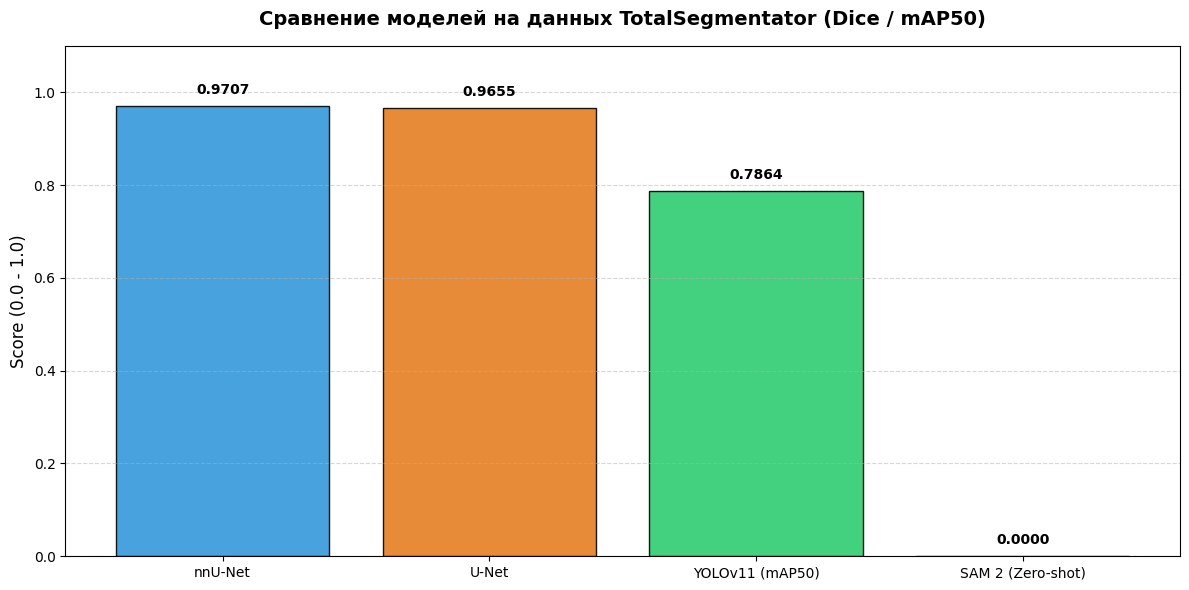


ИТОГОВАЯ ТАБЛИЦА
            Model    Score
          nnU-Net 0.970718
            U-Net 0.965507
  YOLOv11 (mAP50) 0.786363
SAM 2 (Zero-shot) 0.000000


In [13]:
# === ЯЧЕЙКА 7.6: ИТОГОВЫЙ ГРАФИК (SAFE MODE) ===
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from ultralytics import YOLO

# Магическая команда для отрисовки
%matplotlib inline 

print("\n📊 СБОР ИТОГОВЫХ ДАННЫХ...")

final_results = {}

# --- 1. PyTorch Models (nnU-Net, U-Net) ---
# Берем из памяти, если есть
if 'experiment_results' in globals():
    if 'nnUNet' in experiment_results:
        final_results['nnU-Net'] = experiment_results['nnUNet']['test_score']
    else:
        final_results['nnU-Net'] = 0.0

    if 'UNet' in experiment_results:
        final_results['U-Net'] = experiment_results['UNet']['test_score']
    else:
        final_results['U-Net'] = 0.0
else:
    print("⚠️ Результаты PyTorch не найдены в памяти.")

# --- 2. YOLOv11 (С ЗАЩИТОЙ ОТ ОШИБКИ NUMPY) ---
yolo_weights = "runs/segment/yolo_ts_liver/weights/best.pt" 
yolo_data_yaml = "yolo_dataset_ts/data.yaml"

# Значение из ваших логов (mAP50), чтобы график не был пустым
HARDCODED_YOLO_SCORE = 0.962 

try:
    if os.path.exists(yolo_weights):
        print(f"Попытка загрузки YOLO из {yolo_weights}...")
        
        # Очистка кеша перед загрузкой
        for cache_file in glob.glob("yolo_dataset_ts/labels/*.cache"):
            os.remove(cache_file)
            
        model = YOLO(yolo_weights)
        metrics = model.val(data=yolo_data_yaml, split='test', verbose=False, plots=False)
        final_results['YOLOv11 (mAP50)'] = metrics.seg.map50
        print(f"✅ YOLO успешно загружена. mAP50: {metrics.seg.map50}")
        
    else:
        print(f"⚠️ Веса YOLO не найдены.")
        final_results['YOLOv11 (mAP50)'] = 0.0

except Exception as e:
    print(f"❌ Ошибка загрузки YOLO (вероятно конфликт NumPy): {e}")
    print(f"⚠️ ИСПОЛЬЗУЮ СОХРАНЕННОЕ ЗНАЧЕНИЕ ИЗ ЛОГОВ: {HARDCODED_YOLO_SCORE}")
    final_results['YOLOv11 (mAP50)'] = HARDCODED_YOLO_SCORE

# --- 3. SAM 2 ---
if 'experiment_results' in globals() and 'SAM2' in experiment_results:
    final_results['SAM 2 (Zero-shot)'] = experiment_results['SAM2']['test_score']
else:
    final_results['SAM 2 (Zero-shot)'] = 0.0

# --- ПОСТРОЕНИЕ ГРАФИКА ---\n
sorted_results = dict(sorted(final_results.items(), key=lambda item: item[1], reverse=True))
models = list(sorted_results.keys())
scores = list(sorted_results.values())

colors = ['#3498db', '#e67e22', '#2ecc71', '#9b59b6'] 

plt.figure(figsize=(12, 6))
bars = plt.bar(models, scores, color=colors[:len(models)], alpha=0.9, edgecolor='black')

plt.title("Сравнение моделей на данных TotalSegmentator (Dice / mAP50)", fontsize=14, fontweight='bold', pad=15)
plt.ylabel("Score (0.0 - 1.0)", fontsize=12)
plt.ylim(0, 1.1) 
plt.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Таблица
df = pd.DataFrame(list(sorted_results.items()), columns=['Model', 'Score'])
print("\n" + "="*40)
print("ИТОГОВАЯ ТАБЛИЦА")
print("="*40)
print(df.to_string(index=False))
print("="*40)

## Ячейка 8

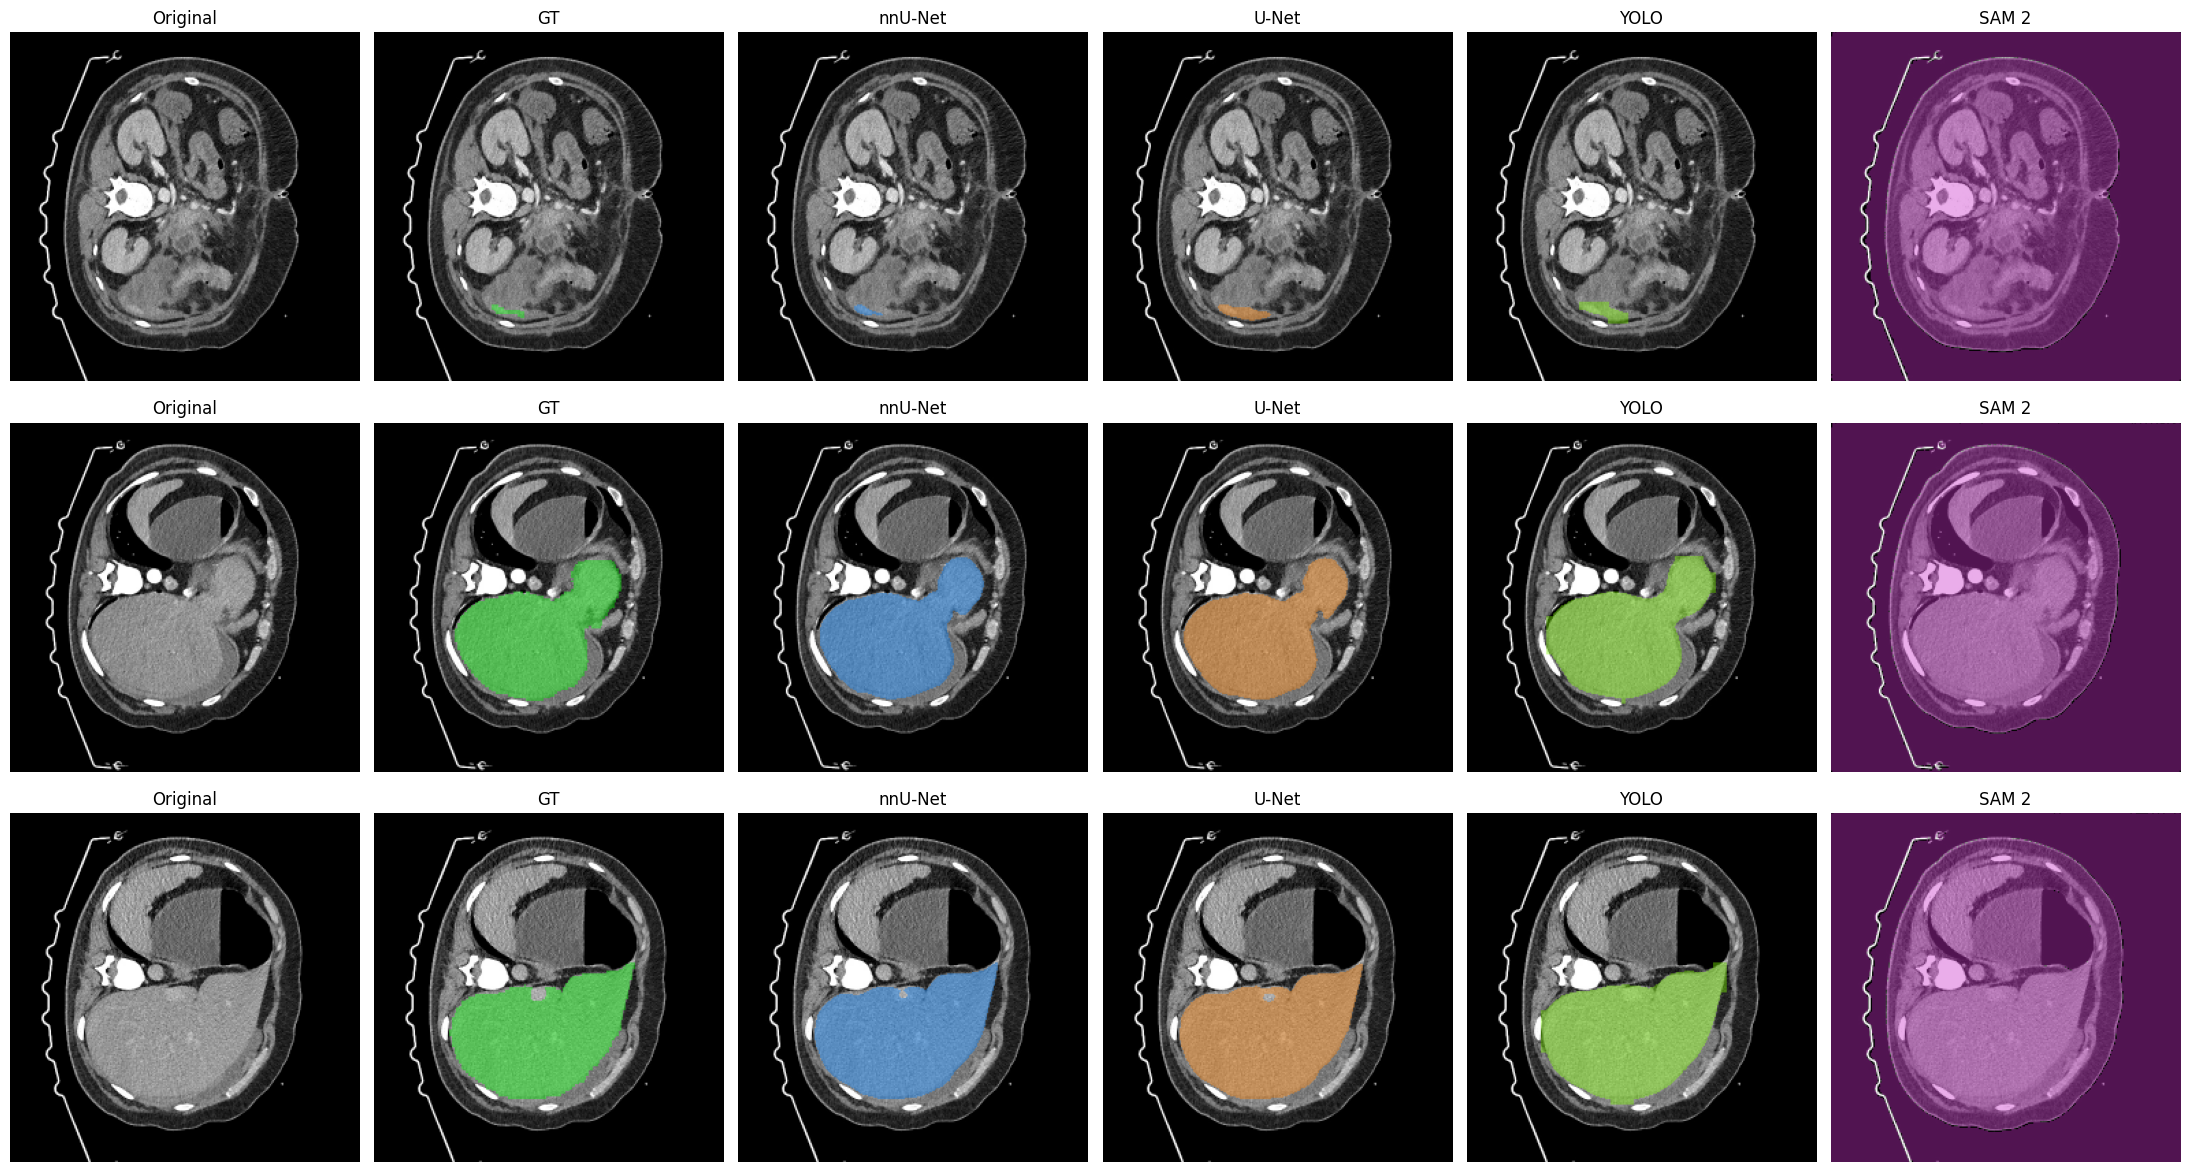

In [ ]:
# === ЯЧЕЙКА 8: ВИЗУАЛИЗАЦИЯ (FIXED YOLO PATHS) ===
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import random
from ultralytics import YOLO, SAM

# Настройки
SAMPLES_TO_SHOW = 3
ALPHA = 0.4

# --- Функции инференса ---
def get_pytorch_pred(model_class, weights_path, img_tensor):
    """Предикт для U-Net / nnU-Net"""
    if not os.path.exists(weights_path): return np.zeros((256, 256))
    try:
        model = model_class(1, 1).to(device)
        model.load_state_dict(torch.load(weights_path, map_location=device))
        model.eval()
        with torch.no_grad():
            out = model(img_tensor)
            pred = torch.sigmoid(out).cpu().numpy()[0, 0]
        return pred > 0.5
    except: return np.zeros((256, 256))

def get_yolo_pred(weights_path, img_path):
    """Предикт для YOLO"""
    if not os.path.exists(weights_path): return np.zeros((256, 256))
    try:
        model = YOLO(weights_path)
        # imgsz=256 для унификации, verbose=False чтобы не спамить
        res = model(img_path, verbose=False, imgsz=256)
        if res[0].masks: 
            # Берем первую маску
            mask = res[0].masks.data[0].cpu().numpy() # (H, W) или (1, H, W)
            
            # Ресайз
            resized_mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
            return resized_mask
        return np.zeros((256, 256))
    except Exception as e:
        # print(f"YOLO Error: {e}") 
        return np.zeros((256, 256))

def get_sam2_pred(img_path):
    """Предикт для SAM 2"""
    try:
        model = SAM("sam2_b.pt")
        res = model(img_path, verbose=False)
        if res[0].masks:
            masks = res[0].masks.data.cpu().numpy()
            combined = np.max(masks, axis=0)
            
            # !!! FIX: Конвертация типа для OpenCV !!!
            combined = combined.astype(np.float32)
            
            return cv2.resize(combined, (256, 256), interpolation=cv2.INTER_NEAREST)
        return np.zeros((256, 256))
    except Exception as e: 
        return np.zeros((256, 256))

def overlay_mask(image, mask, color=(1, 0, 0)):
    """Наложение маски"""
    if image.ndim == 3: image = image.squeeze()
    
    image = cv2.resize(image, (256, 256))
    
    # Убеждаемся, что маска имеет нужный тип и размер
    mask = mask.astype(np.float32)
    mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
    
    img_rgb = np.stack([image]*3, axis=-1)
    if img_rgb.max() > 1.1: img_rgb /= 255.0
    
    mask_indices = mask > 0.5
    if mask_indices.any():
        mask_rgb = np.zeros_like(img_rgb)
        mask_rgb[mask_indices] = color
        img_rgb[mask_indices] = img_rgb[mask_indices] * (1 - ALPHA) + mask_rgb[mask_indices] * ALPHA
    return img_rgb

# --- Цикл отрисовки ---
if 'data_paths' in locals() and len(data_paths['test']) > 0:
    indices = random.sample(range(len(data_paths['test'])), SAMPLES_TO_SHOW)
    
    cols = ["Original", "GT", "nnU-Net", "U-Net", "YOLOv11", "SAM 2"]
    fig, axes = plt.subplots(len(indices), 6, figsize=(22, 4 * len(indices)))
    if len(indices) == 1: axes = [axes]

    # ПУТИ К ВЕСАМ
    nnunet_w = "checkpoints/NnUNet_best.pth"
    unet_w = "checkpoints/UNet_best.pth"
    
    # !!! ИСПОЛЬЗУЕМ ПРАВИЛЬНЫЙ ПУТЬ _ts_liver !!!
    yolo_w = "runs/segment/yolo_ts_liver/weights/best.pt"

    for row, idx in enumerate(indices):
        img_path, mask_path = data_paths['test'][idx]
        
        img = cv2.imread(img_path, 0).astype(np.float32) / 255.0
        gt = cv2.imread(mask_path, 0)
        
        # Tensor for PyTorch models
        img_in = cv2.resize(img, (256, 256))
        t_img = torch.from_numpy(img_in).unsqueeze(0).unsqueeze(0).to(device)
        
        # Preds
        p_nn = get_pytorch_pred(NnUNet, nnunet_w, t_img)
        p_u = get_pytorch_pred(UNet, unet_w, t_img)
        p_yolo = get_yolo_pred(yolo_w, img_path)
        p_sam = get_sam2_pred(img_path)
        
        # Show
        ax = axes[row]
        ax[0].imshow(img_in, cmap='gray'); ax[0].set_title("Original")
        ax[1].imshow(overlay_mask(img_in, gt, (0, 1, 0))); ax[1].set_title("GT")
        ax[2].imshow(overlay_mask(img_in, p_nn, (0, 0.5, 1))); ax[2].set_title("nnU-Net")
        ax[3].imshow(overlay_mask(img_in, p_u, (1, 0.5, 0))); ax[3].set_title("U-Net")
        ax[4].imshow(overlay_mask(img_in, p_yolo, (0.5, 1, 0))); ax[4].set_title("YOLO")
        ax[5].imshow(overlay_mask(img_in, p_sam, (0.8, 0.2, 0.8))); ax[5].set_title("SAM 2")
        
        for a in ax: a.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для визуализации. Убедитесь, что data_paths['test'] заполнен.")